## Leitura de imagens não usadas no treinamento para teste de resultado

#### Validação Multiclasse


In [1]:
import torch
from transformers import ViTForImageClassification
import pytorch_lightning as pl
import torch.nn as nn

import sys
import os

# dir_raiz = os.path.abspath(os.path.join(os.getcwd(), '..'))
# sys.path.append(dir_raiz)
from classes.modelo import Modelo
from classes.modelo_custom import ModeloCustom
from classes.modelo_binario import ModeloBin


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from classes.Validate import Validate

d:\AREA_DE_TRABALHO\Faculdade_8_Periodo\TCC\VIT-cric\vit-dynamic-patches\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_classes = 6
learning_rate = 0.0001

### Load Modelo Completo

In [3]:
vl = Validate(num_class=num_classes, learning_rate=learning_rate, model_name="multiclass")

d:\AREA_DE_TRABALHO\Faculdade_8_Periodo\TCC\VIT-cric\vit-dynamic-patches\env\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [4]:
vl.load_default_model("models/modelo_vit_gpu.pth")

### Load Checkpoint

In [4]:
vl.load_checkpoint_model('models/checkpoint/epoch=80-val_loss=0.77-val_accuracy=0.74.ckpt')

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

### Labels

In [4]:
labels = {'Negative for intraepithelial lesion': 0, 'Positive for intraepithelial lesion': 1}

In [4]:
labels = {'ASC-H': 0, 'ASC-US': 1, 'HSIL': 2, 'LSIL': 3, 'Negative for intraepithelial lesion': 4, 'SCC': 5}

### Avaliar pelo conjunto de Validação


In [ ]:
vl.validate_show("data/base_treinamento/validation/Negative for intraepithelial lesion", labels)

In [ ]:
vl.validate_show("data/base_treinamento/validation/Positive for intraepithelial lesion", labels)

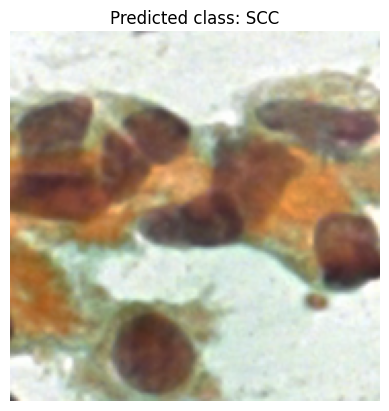

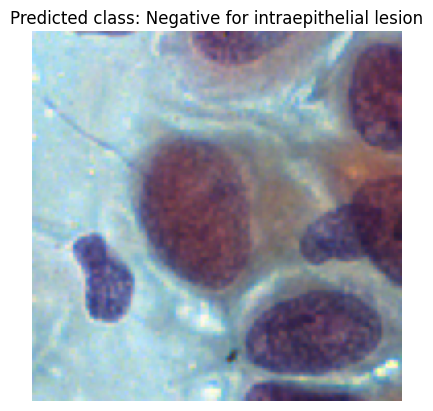

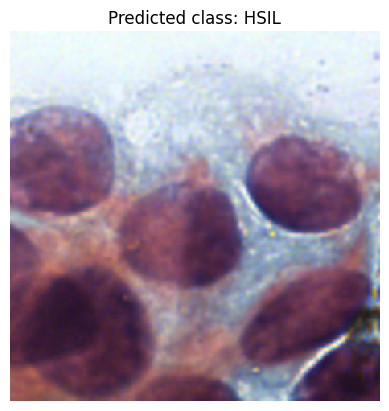

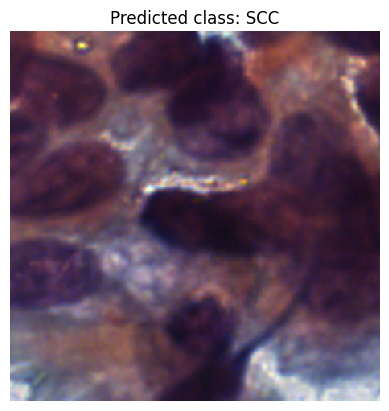

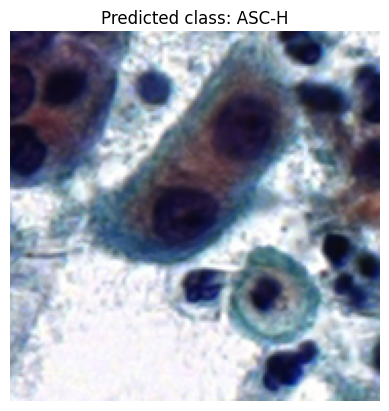

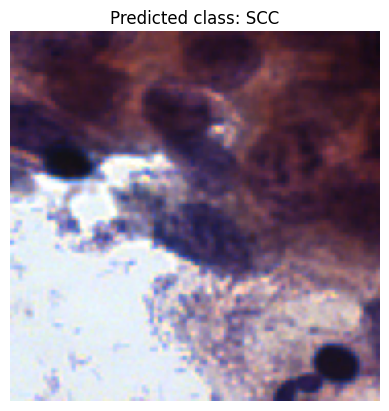

In [5]:
vl.validate_show("data/base_treinamento/validation/ASC-H", labels)

In [ ]:
vl.validate_show("data/base_treinamento/validation/ASC-US", labels)

In [ ]:
vl.validate_show("data/base_treinamento/validation/HSIL", labels)

In [ ]:
vl.validate_show("data/base_treinamento/validation/LSIL",labels)

In [ ]:
vl.validate_show("data/base_treinamento/validation/Negative for intraepithelial lesion", labels)

In [ ]:
vl.validate_show("data/base_treinamento/validation/SCC", labels)

### Avaliar pelo conjunto de Teste


### Binario

Processando imagens...: 1356 Imagens [01:20, 16.86 Imagens/s]
Processando imagens...: 1356 Imagens [01:19, 16.98 Imagens/s]
Processando imagens...: 951 Imagens [00:55, 17.23 Imagens/s]
Processando imagens...: 951 Imagens [00:54, 17.42 Imagens/s]


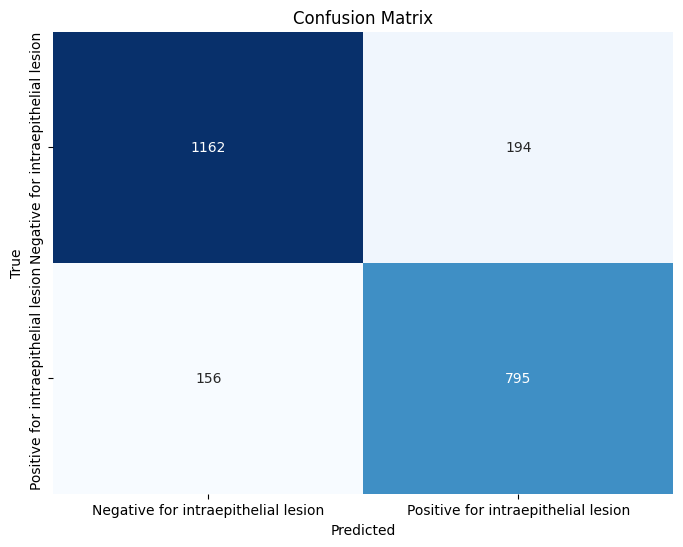

{'Negative for intraepithelial lesion': [1162, 194],
 'Positive for intraepithelial lesion': [156, 795]}

In [5]:
vl.load_default_model("models/modelo_vit_gpu.pth")
vl.generate_confusion_matrix(main_path="data/base_treinamento/test", labels=labels)


d:\AREA_DE_TRABALHO\Faculdade_8_Periodo\TCC\VIT-cric\vit-dynamic-patches\env\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

Processando imagens...: 185 Imagens [00:38,  4.86 Imagens/s]
Processando imagens...: 122 Imagens [00:22,  5.31 Imagens/s]
Processando imagens...: 341 Imagens [01:04,  5.31 Imagens/s]
Processando imagens...: 272 Imagens [00:52,  5.16 Imagens/s]
Processando imagens...: 1356 Imagens [04:40,  4.83 Imagens/s]
Processando imagens...: 33 Imagens [00:06,  5.16 Imagens/s]


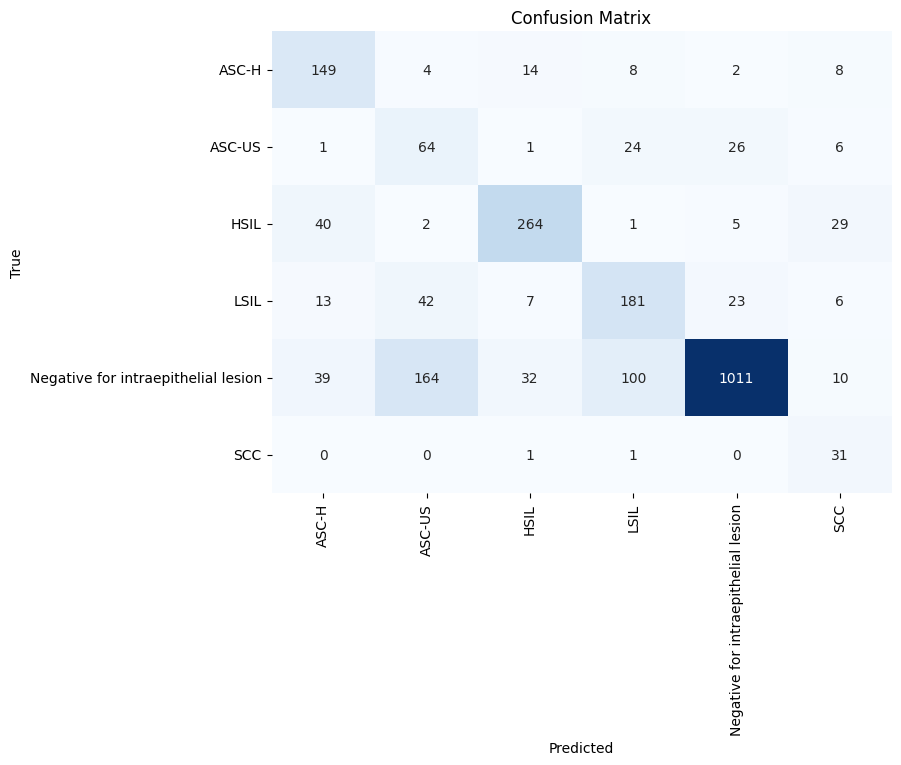

In [7]:
vl.load_checkpoint_model('resultados/testes/google-224-model/normal/100_epocas_ALL_sem_overffiting/epoch=80-val_loss=0.77-val_accuracy=0.74.ckpt')
vl.generate_confusion_matrix(main_path="data/base_treinamento/test", labels=labels)